# Model testing

Evaluate the saved XGBoost regressor on the held-out test dataset.

### Imports

In [21]:
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


### Variables

In [22]:
target_col = "movie_score"
drop_cols = ["movie_score", "averageRating", "numVotes", "Unnamed: 0", "_orig_order"]

### Retrieve data

In [23]:
useBackslash = True
testDatasetPath = r'.\data\test_dataset.csv' if useBackslash else r'./data/test_dataset.csv'
final_model = joblib.load("xgb_reg_movie_number_votes_over_1000.joblib")
df_test = pd.read_csv(testDatasetPath, sep=";")


### Prepare test data

In [24]:
# Load model and data, transform the log scalled data back
y_true = np.expm1(df_test[target_col].values)
X_test = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns])


### Create prediction on test

In [25]:
# Predict and turn the prediction back to normal scale 
y_pred = np.expm1(final_model.predict(X_test))

### Calculate MAE, RMSE and R^2

In [26]:
# Metrics (only if ground truth available)
if y_true is not None:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")
else:
    print("Ground-truth 'movie_score' not found in test set; only predictions are available.")


MAE:  12860.2825
RMSE: 51151.2553
R2:   0.2176


### Create a preview dataframe

In [27]:
# Preview predictions
preview = pd.DataFrame({"predicted_movie_score": y_pred, "residual": y_pred - y_true})
if y_true is not None:
    preview.insert(0, "actual_movie_score", y_true)


### Create a dataframe of feature importance

In [28]:
importances = final_model.feature_importances_

# Feature names (if trained with a DataFrame)
feature_names = final_model.feature_names_in_

# Create sorted DataFrame
top_10_features = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)

### Graph over residuals

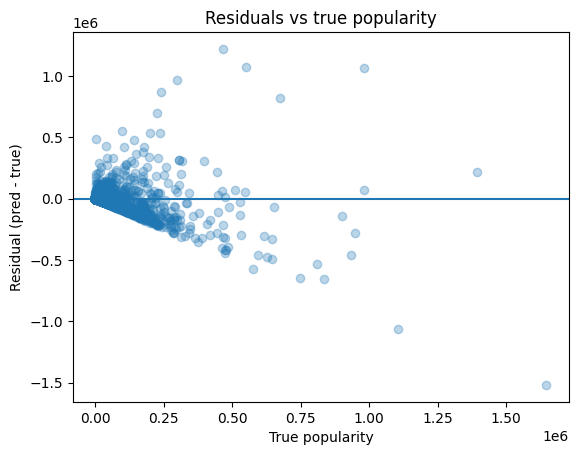

In [29]:
residuals = y_pred - y_true

plt.figure()
plt.scatter(y_true, residuals, alpha=0.3)
plt.axhline(0)
plt.xlabel("True popularity")
plt.ylabel("Residual (pred - true)")
plt.title("Residuals vs true popularity")
plt.show()


### Bias plot

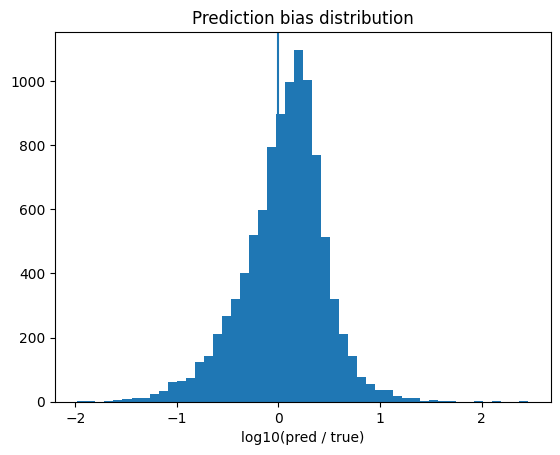

In [30]:
ratio = y_pred / (y_true + 1e-9)
plt.figure()
plt.hist(np.log10(ratio), bins=50)
plt.axvline(0)  # log10(1)
plt.xlabel("log10(pred / true)")
plt.title("Prediction bias distribution")
plt.show()

